# Grade vs. Hits

**Goal:** Investigate whether the category embedding or feeding in the raw hits and holes gives better performance.

In [1]:
import numpy as np
import h5py
import sys

sys.path.append("..")
from usefulFcts import *
from trainNet import *
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## IP3D Category

There are 14 categories used to define the ip3d category.

<img src="../figures/trkCategories.png" width="400">

It appears that
    - nPixHoles
    - nSCTHoles
    - expectInnermostPixelLayerHit
    - expectNextToInnermostPixelLayerHit
are the four variables that aren't included in Michael's `convert_Root_to_array.py` script. 

- Maybe I don't need the holes because this is just when the hits are 0 given that there is one expected?
- But I think I need the expected hits in L0 and L1!

### MISSING VARS

**I think I'm missing the shared and split hits in L1 variables!!**



## Load in the data and the models 


In [2]:
load_model=True
modelDir = "../models/mc16d"

leffs = []
ceffs = []
beffs = []
labels = ["grade","hits"]

discs = []

for catTag, doEmbedding in zip(labels, [True,False]):


    # Open the dataset
    dataTag = "3m_15trks_sd0_sz0_ptfrac_dr_{}_sd0_rev_logNorm".format(catTag)
    f = h5py.File("../data/mc16d/data_{}.hdf5".format(dataTag),"r")
    
    X  = f['X_test'][:]
    y  = f['y_test'][:]
    ix = f['ix_test'][:]

    nJets, nTrks, nFeatures = X.shape
    
    embedTag = 'gradeEmbed' if doEmbedding else 'noEmbed'
    modelName = "LSTM_50units_10dense_{}_{}".format(dataTag,embedTag)
    
    # Open the model
    m = myLSTM(modelName=modelName, modelDir=modelDir, 
               loadModel=load_model, doEmbedding=doEmbedding)

    m.model.summary()
    
    # Plot the training curves
    if not doEmbedding:
        print("Loss / acc for {}".format(m.modelName))
        trainingMetrics(m.modelName,modelDir=modelDir)

    # Get the efficiencies
    (l_eff, c_eff, b_eff), d = sigBkgEff(m, X, y, ix, returnDisc=True)#, tag=tag, subDir=subDir)
    

    leffs.append(l_eff)
    ceffs.append(c_eff)
    beffs.append(b_eff)
    
    discs.append(d)
    
    f.close()
    

Initialize method from myModel()
Loading previously trained LSTM
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Continuous_trk_inputs (InputLay (None, 15, 4)        0                                            
__________________________________________________________________________________________________
Categorical_trk_inputs (InputLa (None, 15)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 15, 6)        30          Continuous_trk_inputs[0][0]      
                                                                 Categorical_trk_inputs[0][0]     
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)  

KeyboardInterrupt: 

In [3]:
%%bash
ls ../models/mc16d/LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed_history.hdf5

../models/mc16d/LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed_history.hdf5


In [4]:
m.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 15, 17)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 17)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                13600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 14,154
Trainable params: 14,154
Non-trainable params: 0
_________________________________________________________________


../plottingFcts.py:301: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


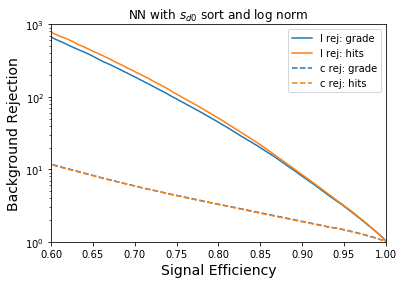

In [5]:
myLabels = ["{} rej: {}".format(bkg, label) \
            for bkg in ['l','c'] for label in labels[:2]]

plotROC(beffs[:2]*2, leffs[:2]+ceffs[:2], myLabels, 
        colors = ['C0','C1']*2,
        styles = ['-','-','--','--'],
        title="NN with $s_{d0}$ sort and log norm",
        tag="grade_vs_hits",subDir="mc16d")

Question: Is this spike in the discriminant being caused by jets that don't have any tracks? (And are therefore set to their default values.)

In [6]:
X.shape

(1500000, 15, 17)

In [7]:
trackless_mask = (np.sum(X,axis=(1,2)) == 0)

In [8]:
trackless_mask = (np.sum(X,axis=(1,2)) == 0)
trackless_mask.sum() / trackless_mask.shape[0]

0.015801333333333334

In [9]:
disc_0trks = d[trackless_mask]

In [10]:
np.min(disc_0trks), np.max(disc_0trks)

(-1.754388, -1.754388)

Conclusion: This spike was definitely due to the default value for trackless jets.

**Validation this Refactored Code:**

1. Look at the distribution of the continuous inputs 

2. Compare with model trained with the older version of the code


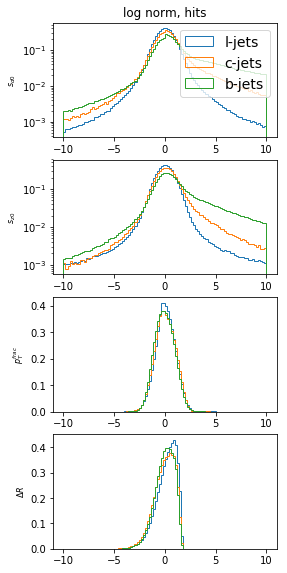

In [11]:
plotInputs([X], [y], ['log norm, hits'], 
           varRanges=[[(-10,10), (-10,10), (-10,10), (-10,10)]])

Ok, these plots look the same as the ones that I had before with the code from my AI_repo.


**Next:** Evaluate a previously trained model on the new version of the inputs

Below is the model trained with the AI_repo code:

(Note: This probably won't work if somebody else tries to run my notebook.)

In [12]:
%%bash
ls /u/ki/nhartman/nfs/AI_Project/models/LSTM_50units_10dense_5m_15trks_catEmbed_sd0_rev_logNorm.h5

/u/ki/nhartman/nfs/AI_Project/models/LSTM_50units_10dense_5m_15trks_catEmbed_sd0_rev_logNorm.h5


In [13]:
'''
Note: I had to rebuild the model and then load in the weights b/c when I tried to 
do it another way, some tensors datatypes for models with different versions of
python conflicted with each other.
'''
prev_m = myLSTM(doEmbedding=True, timeSteps=nTrks, 
                loadModel=False, nFeatures=5, 
                modelDir='/u/ki/nhartman/nfs/AI_Project/models/', 
                #dataTag='5m_15trks_catEmbed_sd0_rev_logNorm',
                modelName='LSTM_50units_10dense_5m_15trks_catEmbed_sd0_rev_logNorm')

Initialize method from myModel()
Building the baseline LSTM


In [14]:
prev_m.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Continuous_trk_inputs (InputLay (None, 15, 4)        0                                            
__________________________________________________________________________________________________
Categorical_trk_inputs (InputLa (None, 15)           0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 15, 6)        30          Continuous_trk_inputs[0][0]      
                                                                 Categorical_trk_inputs[0][0]     
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           11400       model_1[1][0]                    
__________

In [15]:
prev_m.model.weights

[<tf.Variable 'embedding_1_1/embeddings:0' shape=(15, 2) dtype=float32_ref>,
 <tf.Variable 'lstm_1_2/kernel:0' shape=(6, 200) dtype=float32_ref>,
 <tf.Variable 'lstm_1_2/recurrent_kernel:0' shape=(50, 200) dtype=float32_ref>,
 <tf.Variable 'lstm_1_2/bias:0' shape=(200,) dtype=float32_ref>,
 <tf.Variable 'dense_1_2/kernel:0' shape=(50, 10) dtype=float32_ref>,
 <tf.Variable 'dense_1_2/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_2_2/kernel:0' shape=(10, 4) dtype=float32_ref>,
 <tf.Variable 'dense_2_2/bias:0' shape=(4,) dtype=float32_ref>]

In [16]:
'''
Load in the weights from the AI repo
'''
weightFile = "/u/ki/nhartman/nfs/AI_Project/models/LSTM_50units_10dense_5m_15trks_catEmbed_sd0_rev_logNorm.h5"
prev_m.model.load_weights(weightFile)

In [17]:
X.shape

(1500000, 15, 17)

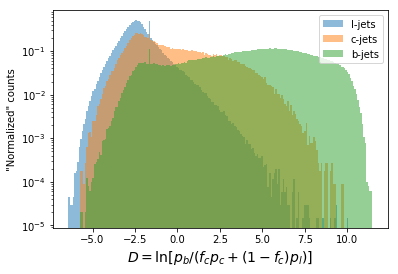

In [18]:
# Add the new roc curve to the list

dataTag = "3m_15trks_sd0_sz0_ptfrac_dr_grade_sd0_rev_logNorm"
f = h5py.File("../data/mc16d/data_{}.hdf5".format(dataTag),"r")

new_X  = f['X_test'][:]
new_y  = f['y_test'][:]
new_ix = f['ix_test'][:]

(l_eff, c_eff, b_eff), d = sigBkgEff(prev_m, new_X, new_y, new_ix, returnDisc=True)#, tag=tag, subDir=subDir)
 
f.close()

In [19]:
leffs.append(l_eff)
ceffs.append(c_eff)
beffs.append(b_eff)

discs.append(d)

labels = labels + ['model trained from AI repo']

First off: Compare *all* of the roc curves

../plottingFcts.py:301: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


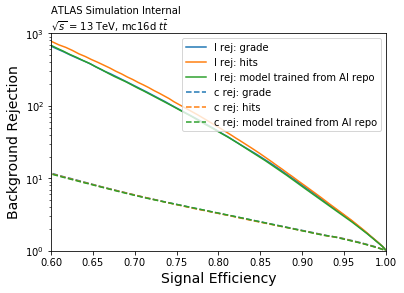

In [20]:
myLabels = ["{} rej: {}".format(bkg, label) \
            for bkg in ['l','c'] for label in labels]

plotROC(beffs*2, leffs+ceffs, myLabels, 
        colors = ['C0','C1','C2']*2,
        styles = ['-','-','-','--','--','--'])

Ok, so it appears that the model trained on the buggy inputs recovers the performance gains when we evaluate it on the inputs with the $\Delta R$ bug fixed.

Just to confirm to myself that this in fact *was* the issue, let's overlay the plot with the model trained and evaluated on the *buggy* inputs.

In [21]:
# Add the new roc curve to the list
dataDir = "/u/ki/nhartman/nfs/AI_Project/data/"
dataFile = "myData_15trks_5m_sd0_rev_logNorm.hdf5"
f = h5py.File(dataDir+dataFile,"r")

prev_X  = f['X_test'][:]
prev_y  = f['y_test'][:]
prev_ix = f['ix_test'][:]

f.close()

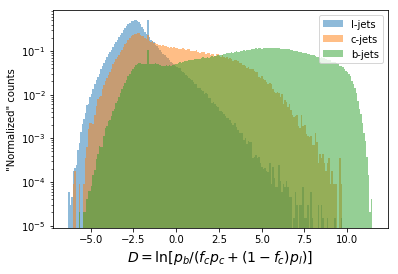

In [22]:
(l_eff, c_eff, b_eff), d = sigBkgEff(prev_m, prev_X, prev_y, prev_ix, returnDisc=True)
#,tag=tag,subDir=subDir) 

In [23]:
leffs.append(l_eff)
ceffs.append(c_eff)
beffs.append(b_eff)

discs.append(d)

labels = labels + ['model trained + eval on inputs w/ $\Delta R$ bug']

../plottingFcts.py:301: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


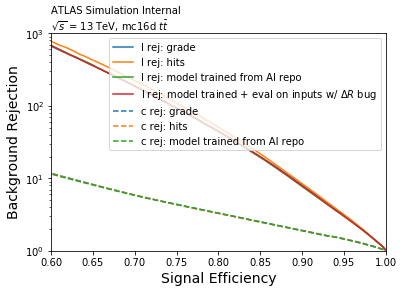

In [24]:
myLabels = ["{} rej: {}".format(bkg, label) \
            for bkg in ['l','c'] for label in labels]

plotROC(beffs*2, leffs+ceffs, myLabels, 
        colors = ['C0','C1','C2','C3']*2,
        styles = ['-','-','-','-','--','--','--'])#,
        #title="NN with $s_{d0}$ sort and log norm",
        #tag="cf_AI_repo",subDir="mc16d")

To simplify the story a bit, remake this plot, but w/o the hits plot.

../plottingFcts.py:301: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


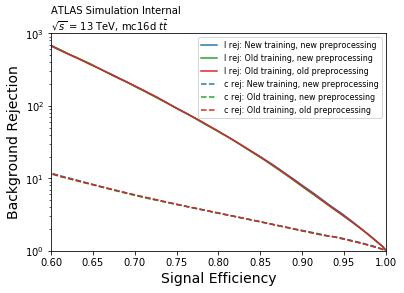

In [25]:
AI_labels = ['New training, new preprocessing',
             'Old training, new preprocessing',
             'Old training, old preprocessing']

myLabels = ["{} rej: {}".format(bkg, label) \
            for bkg in ['l','c'] for label in AI_labels]

AI_leffs = [leffs[0]] + leffs[2:]
AI_ceffs = [ceffs[0]] + ceffs[2:]
AI_beffs = [beffs[0]] + beffs[2:]

plotROC(AI_beffs*2, AI_leffs+AI_ceffs, myLabels, 
        colors = ['C0','C2','C3']*2,
        styles = ['-','-','-','--','--','--'],
        tag="cf_AI_repo",subDir="mc16d",legFontSize=8)

So, when I train with the new inputs, I see the *same* improvements as before.

When I was debugging the above studies, I looked at the distributions for the jets broken down by flavor, and I thought they were interesting distributions to keep and look at!


In [26]:
import pandas as pd
import xarray as xr

filepath = "../data/mc16d/"
data_tag = "3m_15trks_sd0_rev"

jet_df = pd.read_hdf('{}/jet_{}.h5'.format(filepath,data_tag), key='jet_df')
trk_xr = xr.open_dataarray('{}/trk_{}.nc'.format(filepath,data_tag))


In [27]:
list(trk_xr.coords['var'].values)

['sd0',
 'sz0',
 'ip3d_grade',
 'ip3d_llr',
 'pt',
 'eta',
 'theta',
 'phi',
 'orig',
 'algo',
 'nNextToInnHits',
 'nInnHits',
 'nBLHits',
 'nsharedBLHits',
 'nsplitBLHits',
 'nPixHits',
 'nPixHoles',
 'nsharedPixHits',
 'nsplitPixHits',
 'nSCTHits',
 'nSCTHoles',
 'nsharedSCTHits',
 'expectBLayerHit',
 'expectInnermostPixelLayerHit',
 'expectNextToInnermostPixelLayerHit',
 'ptfrac',
 'dr']

In [28]:
trkInputs = list(trk_xr.coords['var'].values)

In [29]:
if 'sd0' in trkInputs:
    print('True')

True


In [30]:
np.sum(jet_df.ip3d_ntrk == 0) / len(jet_df.index)

0.014785

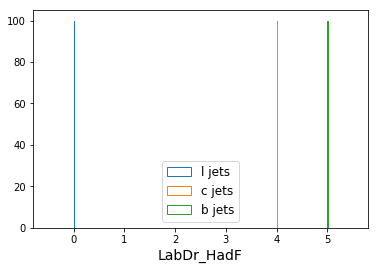

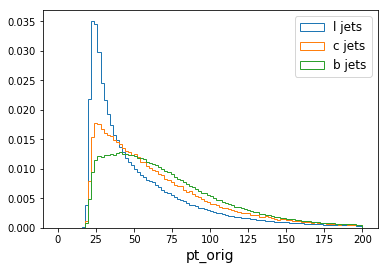

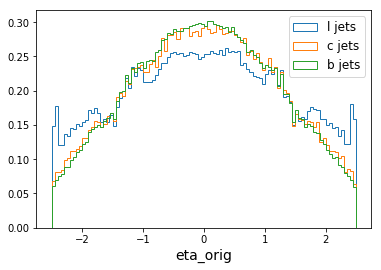

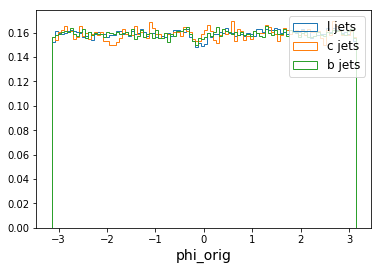

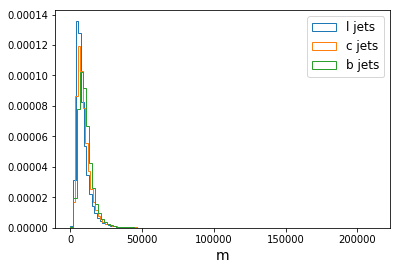

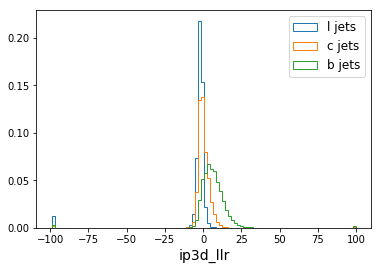

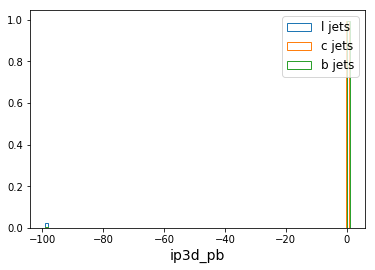

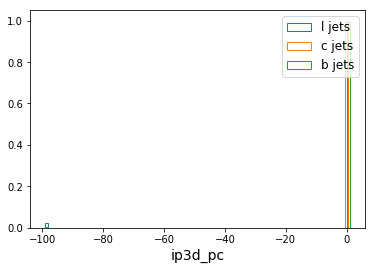

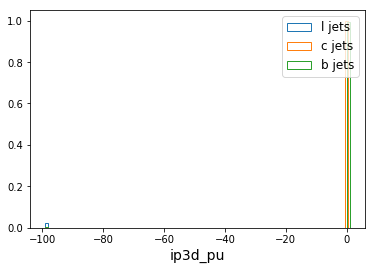

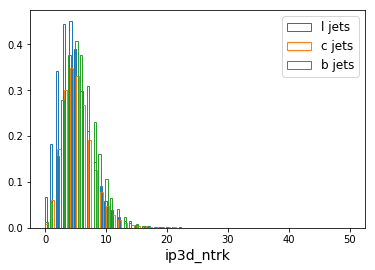

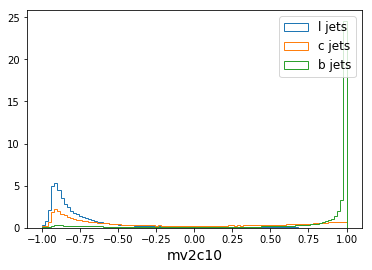

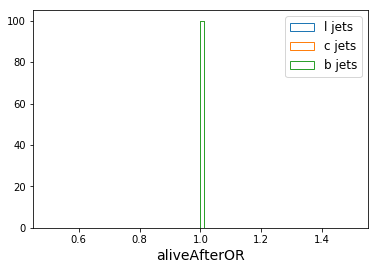

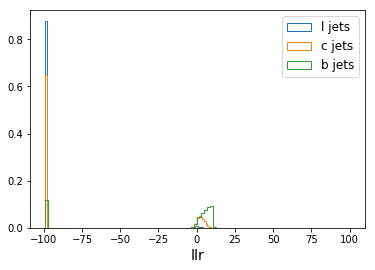

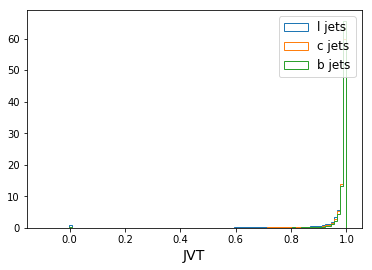

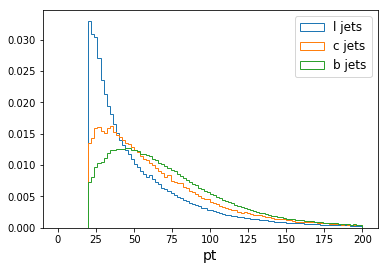

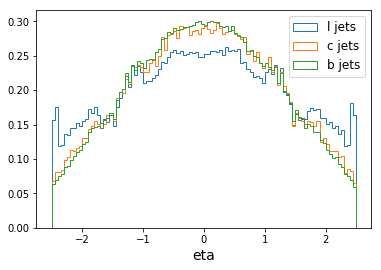

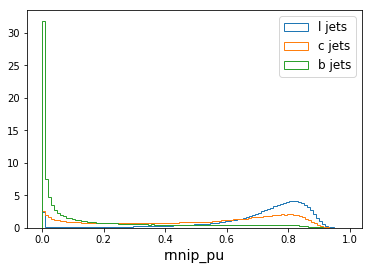

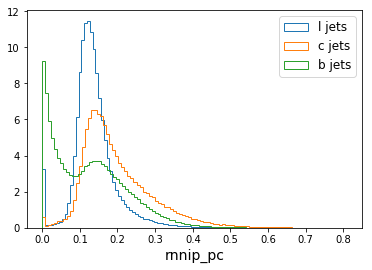

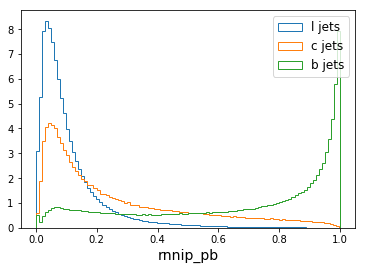

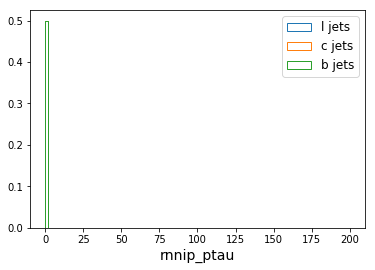

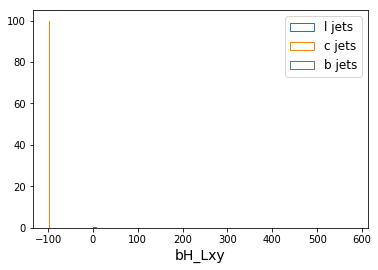

In [31]:
for c in jet_df.columns:

    plt.figure()
    
    for pdg, flav in zip([0,4,5],['l','c','b']):

        myRange = (0,200) if "pt" in c else None
        
        plt.hist(jet_df.loc[(jet_df.LabDr_HadF==pdg),c], 
                 density=True, bins=100, range=myRange, 
                 histtype="step",label='{} jets'.format(flav))

    plt.legend(fontsize=12)
    plt.xlabel(c,fontsize=14)
    plt.show()

## 2. Normalizing the hits

Ok, so atm, I'm not applying any normalization to the hits, but in principle I could.
This could make it easier for the model to train, and to reduce the training time (even if the accuracy stays the same). 

But as a first step, to get a better intuition for these variables, let's just plot the distribution of the inputs that I'm using presently!


In [32]:
X.shape

(1500000, 15, 17)

Need to modify the plotInputs function to plot different inputs.

In [33]:
cat_inpts = ["nNextToInnHits",
             "nInnHits",
             "nBLHits",
             "nsharedBLHits",
             "nsplitBLHits",
             "nPixHits",
             "nsharedPixHits",
             "nsplitPixHits",
             "nSCTHits",
             "nsharedSCTHits",
             "expectBLayerHit",
             "expectInnermostPixelLayerHit",
             "expectNextToInnermostPixelLayerHit"
             ]

In [34]:
print(len(cat_inpts))

13


In [35]:
cat_ranges = [(0,4),
              (0,4),
              (0,4),
              (0,4),
              (0,4),
              (0,9),
              (0,9),
              (0,9),
              (0,20),
              (0,20),
              (0,4),
              (0,4),
              (0,4)
             ]

In [36]:
X[:,:,4:].shape

(1500000, 15, 13)

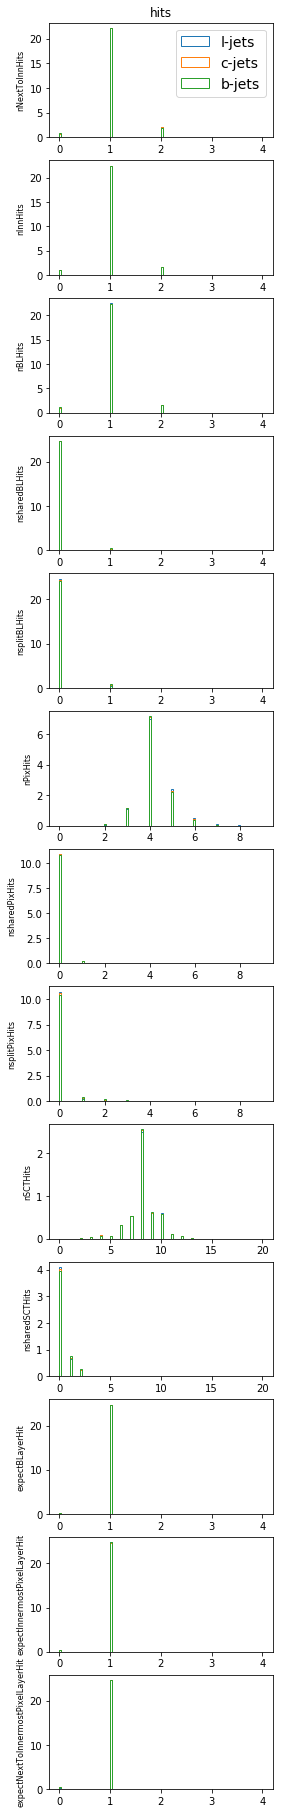

In [37]:
# Just plot the cateogry variables
plotInputs([X[:,:,4:]], [y], ['hits'], 
           trk_vars=cat_inpts, varRanges=[cat_ranges],
           tag='hits_catVars',figSubDir='mc16d')

I made a mistake in my processing script, I didn't mean to include both the variables `nInnHits` and `nBLHits` in the Ntuple.

- I can retrain without the nBLHits variable tomorrow!

In [38]:
trk_xr.loc[0,:,['nInnHits','nBLHits']]

<xarray.DataArray (trk: 15, var: 2)>
array([[2., 2.],
       [2., 2.],
       [1., 1.],
       [1., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)
Coordinates:
    jet      int64 0
  * trk      (trk) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * var      (var) object 'nInnHits' 'nBLHits'

In [39]:
%%bash
ls ../figures/mc16d/

acc_LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed.pdf
disc_LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_grade_sd0_rev_logNorm_gradeEmbed.pdf
disc_LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed.pdf
disc_LSTM_50units_10dense_5m_15trks_catEmbed_sd0_rev_logNorm.pdf
inputs_hits_catVars.pdf
loss_LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed.pdf
roc_cf_AI_repo.pdf
roc_evalNoTrackless.pdf
roc_evalVsTrainNoTrackless.pdf
roc_evalvsNoTrackless.pdf
roc_grade_vs_hits.pdf
roc_nTrain.pdf
roc_spike-10.pdf
roc_trainNoTrackless.pdf
roc_whiten_category.pdf


Initialize method from myModel()
Loading previously trained LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 15, 17)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 17)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                13600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 14,154
Trainable params: 14,154
Non-trainable params: 0
_______

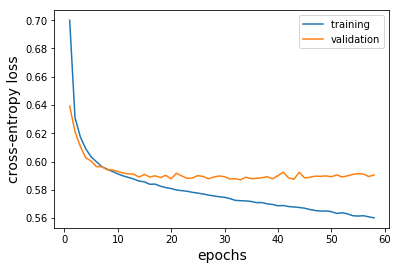

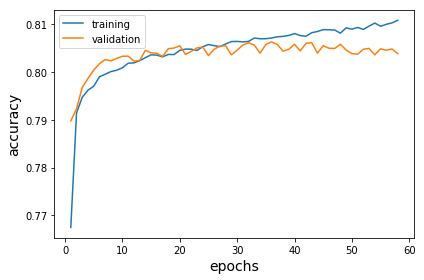

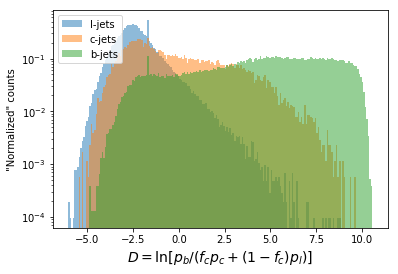

Initialize method from myModel()
Loading previously trained LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 15, 17)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 17)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                13600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 14,154
Trainable params: 14,154
Non-trainable params: 0
_______

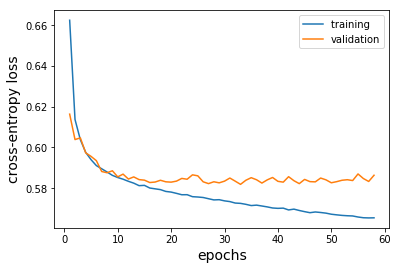

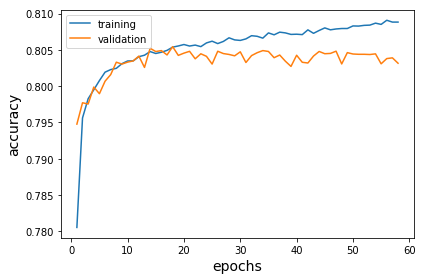

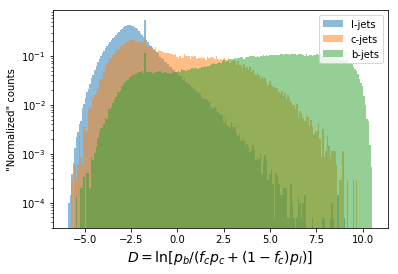

Initialize method from myModel()
Loading previously trained LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 15, 17)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 17)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                13600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 14,154
Trainable params: 14,154
Non-trainable params: 0
_______

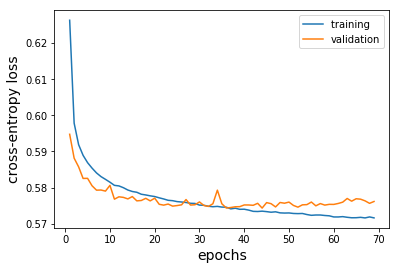

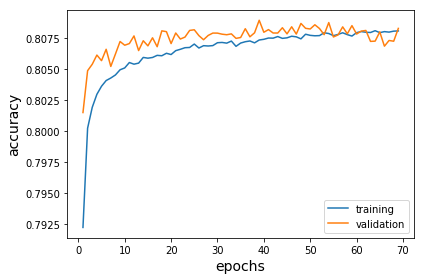

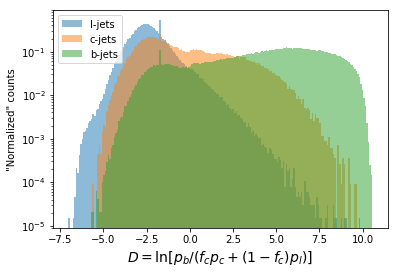

In [3]:
load_model=True
modelDir = "../models/mc16d"
doEmbedding=False
leffs = []
ceffs = []
beffs = []

nJetsTags = ['500k', '1m', '3m']

for jetsTag in nJetsTags:

    # Open the dataset
    dataTag = "{}_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm".format(jetsTag)
    f = h5py.File("../data/mc16d/data_{}.hdf5".format(dataTag),"r")
    
    X  = f['X_test'][:]
    y  = f['y_test'][:]
    ix = f['ix_test'][:]

    # Open the model
    modelName = "LSTM_50units_10dense_{}_noEmbed".format(dataTag)
    m = myLSTM(doEmbedding=doEmbedding, loadModel=load_model, 
               modelName=modelName, modelDir=modelDir)

    m.model.summary()
    
    # Plot the training curves
    if not doEmbedding:
        print("Loss / acc for {}".format(m.modelName))
        trainingMetrics(m.modelName,modelDir=modelDir)

    # Get the efficiencies
    l_eff, c_eff, b_eff = sigBkgEff(m, X, y, ix, returnDisc=False)#, tag=tag, subDir=subDir)
    
    leffs.append(l_eff),
    ceffs.append(c_eff)
    beffs.append(b_eff)
    
    
    f.close()
    

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


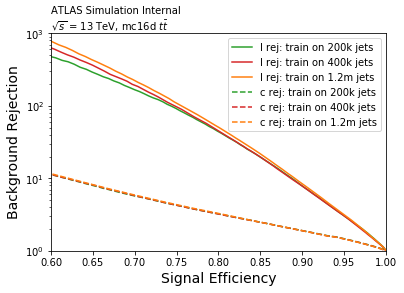

In [4]:
nJets_labels = ['train on {} jets'.format(x) for x in ['200k', '400k', '1.2m']]
myJetsLabels = ["{} rej: {}".format(bkg, label) \
            for bkg in ['l','c'] for label in nJets_labels]

plotROC(beffs*2, leffs+ceffs, myJetsLabels, 
        colors = ['C2','C3','C1']*2,
        styles = ['-','-','-','--','--','--'],
        #title="Varying number of training jets",
        tag="nTrain",subDir="mc16d")

Ok, so this is also good to know. I lose quite a lot by *not* training on the full sample of jets!

So I'll continue to train models with the training set of 1.2m jets for the rest of my studies.

From talking with Michael on 4 Oct, he told me a good thing to try next would be to whiten the inputs.

However, when I tried whitening the variables :
- expectBLayerHit
- expectInnermostPixelLayerHit
- expectNextToInnermostPixelLayerHit,

which all had mean 1 and variance 0, so it was thowing a divide by 0 warning.

Since these varaibles were practically always 1, I wouldn't expect that the performance of the net was driven by these variables, so I decided to *remove* them from my list of *hits* type inputs to see if the resulting distribution was impacted at all.


One more comparison plot:
- Remove the `nBLHits` variable (idk why I ever included it in the first place, it was a type-O). 

In [5]:
m.modelName

'LSTM_50units_10dense_3m_15trks_sd0_sz0_ptfrac_dr_hits_sd0_rev_logNorm_noEmbed'

In [6]:
%%bash
ls ../models/mc16d/LSTM_50units_10dense_3m_15trks_sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nBLHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_sd0_rev.hdf5

../models/mc16d/LSTM_50units_10dense_3m_15trks_sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nBLHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_sd0_rev.hdf5


In [8]:
# sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nBLHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits
# sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nSCTHoles_nsharedSCTHits
# sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits
# sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nSCTHoles_nsharedSCTHits_logNorm_ptfrac_dr
# sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_logNorm_ptfrac_dr


In [9]:
from keras.models import load_model

In [10]:
# model0 = load_model("../models/mc16d/LSTM_50units_10dense_3m_15trks_sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nBLHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_sd0_rev.hdf5")

In [11]:
leffs = [leffs[2]]
ceffs = [ceffs[2]]
beffs = [beffs[2]]

13 trk features
Initialize method from myModel()
Loading previously trained LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 15, 13)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 13)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 13,354
Trainable params: 13,354
Non-trainable p

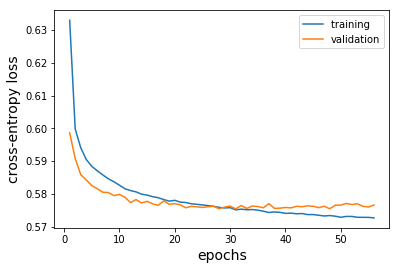

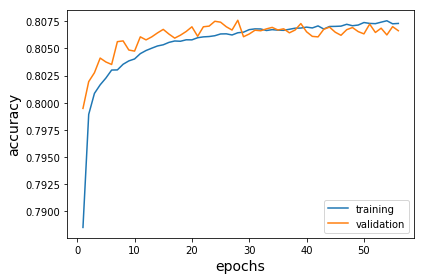

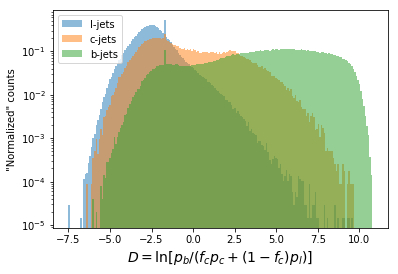

14 trk features
Initialize method from myModel()
Loading previously trained LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 15, 14)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 14)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                13000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 13,554
Trainable params: 13,554
Non-trainable p

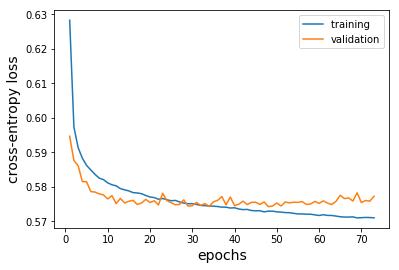

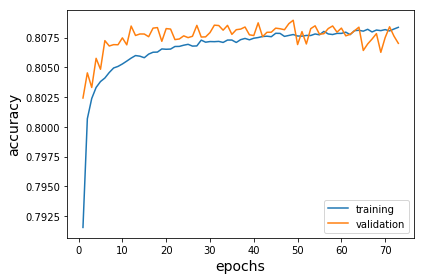

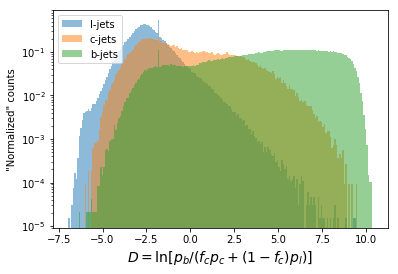

13 trk features
Initialize method from myModel()
Loading previously trained LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 15, 13)            0         
_________________________________________________________________
masking_1 (Masking)          (None, 15, 13)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 13,354
Trainable params: 13,354
Non-trainable p

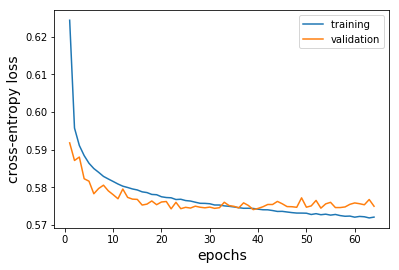

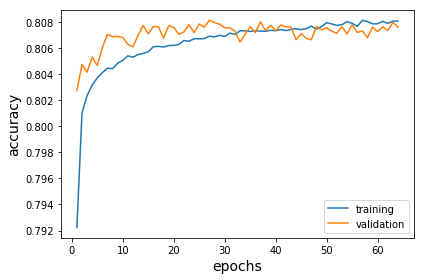

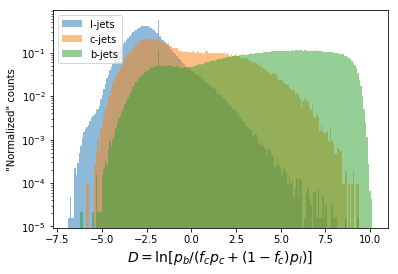

In [12]:
# Just make sure not to include the model where I tried to whiten the nPixHits variable

varList = [ #'sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nBLHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits',
            #'sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nSCTHoles_nsharedSCTHits',
            'sd0_sz0_logNorm_ptfrac_dr_norm_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits',
            'sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nSCTHoles_nsharedSCTHits_logNorm_ptfrac_dr',
            'sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nPixHits_nsharedPixHits_nsplitPixHits_nSCTHits_nsharedSCTHits_logNorm_ptfrac_dr'
          ]

# For simplicity, I'm just going to append these variables to the other effs lists
for vStr in varList:
    
    # Load in the datafile
    dataTag = "3m_15trks_{}_sd0_rev".format(vStr)
    f = h5py.File("../data/mc16d/data_{}.hdf5".format(dataTag),"r")
    
    X  = f['X_test'][:]
    y  = f['y_test'][:]
    ix = f['ix_test'][:]
    
    f.close()
    
    nJets, nTrks, nFeatures = X.shape
    print('{} trk features'.format(nFeatures))
    
    
    
    # Load in the model
    m = myLSTM(dataTag=dataTag, modelDir=modelDir, timeSteps=nTrks,
               nFeatures=nFeatures, loadModel=load_model, doEmbedding=False)

    m.model.summary()
    
    # Plot the training curves
    if not doEmbedding:
        print("Loss / acc for {}".format(m.modelName))
        trainingMetrics(m.modelName,modelDir=modelDir)
    
    
    # Get the efficiencies
    l_eff, c_eff, b_eff = sigBkgEff(m, X, y, ix) #, returnDisc=True)#, tag=tag, subDir=subDir)
    
    leffs.append(l_eff)
    ceffs.append(c_eff)
    beffs.append(b_eff)
    
    #discs.append(d)


../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


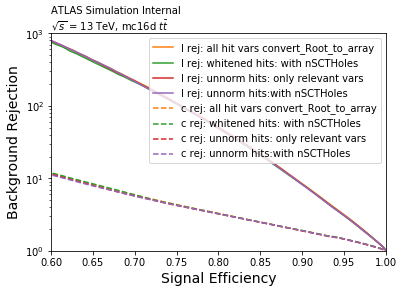

In [13]:
# Make the roc plot
labels = [#'whitened hits: duplicate nBLHits variable included',
          #'whitened hits: w/o nBLHits variable included',
          'whitened hits: with nSCTHoles',
          'unnorm hits: only relevant vars',
          'unnorm hits:with nSCTHoles'
          ]


myLabels = ["{} rej: {}".format(bkg, label) for bkg in ['l','c'] \
            for label in ['all hit vars convert_Root_to_array']+labels]

plotROC(beffs*2, leffs+ceffs, myLabels, colors=['C1','C2','C3','C4']*2,
        styles=['-']*4+['--']*4,subDir='mc16d')

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


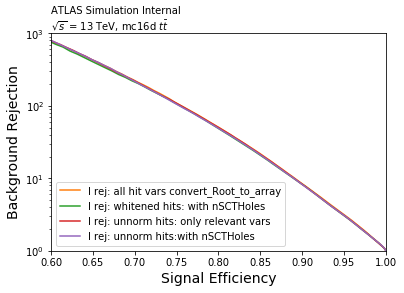

In [14]:
plotROC(beffs, leffs, myLabels[:4], colors=['C1','C2','C3','C4'],
        styles=['-']*4,subDir='mc16d',tag='lrej_hits_options')

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


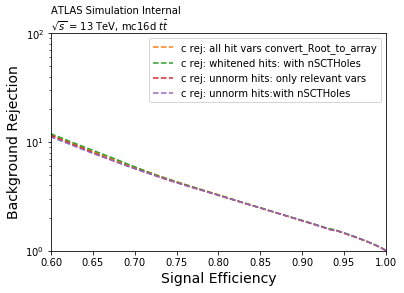

In [15]:
plotROC(beffs, ceffs, myLabels[4:], colors=['C1','C2','C3','C4'],
        styles=['--']*4,subDir='mc16d',ymax=1e2,tag='crej_hits_options')

The below models might not be the most interesting ones to look at.

../plottingFcts.py:398: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


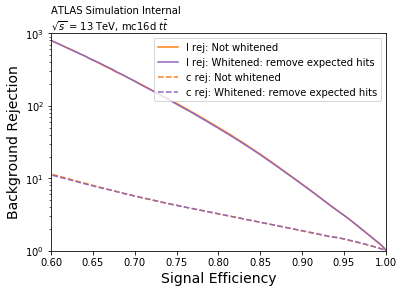

In [16]:
# Make the roc plot
jointNormlabels = ['Not whitened','Whitened: remove expected hits']
myLabels = ["{} rej: {}".format(bkg, label) for bkg in ['l','c'] \
            for label in jointNormlabels]

plotROC(beffs[-2:]*2, leffs[-2:]+ceffs[-2:], myLabels, 
        colors = ['C1','C4']*2,
        styles = ['-','-','--','--'],
        tag="whiten_category",subDir="mc16d")

Ok, so new conclusion:
- It looks like whitening might cause us to lose some info
- Perhaps it might be due to loosing these expected hits variables.

The job with the holes always had NaN losses b/c I can't normalize the variable nPixHoles which doesn't vary.

- It might be interesting to include the nPixHoles *without* whitening to see if it helps at all.

I'm not sure if it's worthwhile to look at a log normalization scheme?


Ok, right away this is *super* good news! But the question remains:

*Are the performance gains coming from the fact that we're giving less useless information, or from the fact that the normalization is actually helping us a lot?*


How I'm going to answer this question:
- Train a model *without* whitening, and removing all the useless variables.
- I really should retrain the purple curve as well, removing the nBLHits (with all these variables whitened). 

Also, the next studies where I'm looking into taking the log norm of some of the variables might help us train more intelligently with the holes!

Next: It seemed like there were two possibilities for whitening the inputs that might be useful.
1. Just whiten them
2. First take the log of the variables that have *shared* or *split* in the variable name.

But, since the $\log(0) \rightarrow -\infty$, it's important to add $\epsilon$ (like $10^{-10}$ to these variables to avoid a dividing by 0 error!

Ok, so the only models that I have for the ablation studies are the ones w/ the whitened hits.

So I guess whether or not I train more models might depend if I'm seeing any gain in performance from these studies